# 1. Load Dependencies

In [5]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

!pip install scikit-tensor-py3
from sktensor import dtensor

import pandas as pd
import numpy as np

import time
import datetime
import copy
import os
import joblib
import copy

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device('cuda')

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('Use GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
Use GPU: Tesla T4


# 2. Helper Functions

In [7]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# 3. Load Data

In [8]:
# Read data

%%time

file_path_train = '/content/drive/My Drive/Colab Notebooks/DATA5703/Data/Dataset/[1109]TrainData_adjusted.csv'
file_path_test = '/content/drive/My Drive/Colab Notebooks/DATA5703/Data/Dataset/[1109]TestData_adjusted.csv'

cols = ['userId', 'gender', 'sport', 'calories',
        'Route_id', 'distance', 'distance_adjusted_sum']

train_df = pd.read_csv(file_path_train, usecols=cols)
test_df = pd.read_csv(file_path_test, usecols=cols)

train_df.rename(columns={'distance': 'workout_distance',
                         'distance_adjusted_sum': 'total_distance'},
                inplace=True)

test_df.rename(columns={'distance': 'workout_distance',
                        'distance_adjusted_sum': 'total_distance'},
               inplace=True)

print(train_df.shape)
print(test_df.shape)

display(train_df.head(1))

(50253, 7)
(12578, 7)


,userId,gender,sport,calories,workout_distance,Route_id,total_distance
0,11889307,unknown,bike,530.0,46.04,0,46.04


CPU times: user 15 s, sys: 2.91 s, total: 17.9 s
Wall time: 2min 15s


# 4. Data Processing

In [9]:
# Encode gender feature

conditions = [
    (train_df['gender'] == 'male'),
    (train_df['gender'] == 'female'),
    (train_df['gender'] == 'unknown')]

choices = [0, 1, 2]

train_df['genderId'] = np.select(conditions, choices, default=0)

conditions = [
    (test_df['gender'] == 'male'),
    (test_df['gender'] == 'female'),
    (test_df['gender'] == 'unknown')]

test_df['genderId'] = np.select(conditions, choices, default=0)

In [10]:
# Encode sport feature

conditions = [
    (train_df['sport'] == 'run'),
    (train_df['sport'] == 'bike'),
    (train_df['sport'] == 'mountain bike')]

choices = [0, 1, 2]

train_df['sportId'] = np.select(conditions, choices, default=0)

conditions = [
    (test_df['sport'] == 'run'),
    (test_df['sport'] == 'bike'),
    (test_df['sport'] == 'mountain bike')]

test_df['sportId'] = np.select(conditions, choices, default=0)

In [11]:
# Load Min-max scaler models

scaler_dic = dict()
features = ['calories', 'distance']

dir = '/content/drive/My Drive/Colab Notebooks/DATA5703/scaler_model/'

for feature in features:
    path = os.path.join(dir, 'scaler_'+feature+'_2.m')
    scaler_dic[feature] = joblib.load(path)

scaler_dic['workout_distance'] = scaler_dic['distance']
scaler_dic['total_distance'] = scaler_dic['distance']
del scaler_dic['distance']

scaler_dic

{'calories': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'total_distance': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'workout_distance': MinMaxScaler(copy=True, feature_range=(0, 1))}

In [12]:
# Apply min max scaler for selected features

%%time


# for features in context_df
for feature in train_df[['calories', 'workout_distance', 'total_distance']].columns:
    # Reshape data using array.reshape(-1, 1) if data has a single feature
    train_df[feature] = scaler_dic[feature].transform(
        train_df[feature].to_numpy().reshape(-1, 1))
    
    test_df[feature] = scaler_dic[feature].transform(
        test_df[feature].to_numpy().reshape(-1, 1))


display(train_df.head(1))

,userId,gender,sport,calories,workout_distance,Route_id,total_distance,genderId,sportId
0,11889307,unknown,bike,0.09517,0.351182,0,0.351182,2,1


CPU times: user 18.2 ms, sys: 1.66 ms, total: 19.9 ms
Wall time: 20.8 ms


In [13]:
# # Fit onehot encoder for categorical features

# OneHot_enc = OneHotEncoder()
# OneHot_enc.fit(pd.concat([train_df[['genderId', 'sportId']], 
#                           test_df[['genderId', 'sportId']]]))

# # Save onehot encoder

# file_path = '/content/drive/My Drive/Colab Notebooks/DATA5703/OneHotEncoder.m'

# joblib.dump(OneHot_enc, file_path)

# Load onehot encoder for categorical features

dir = '/content/drive/My Drive/Colab Notebooks/DATA5703/OneHotEncoder.m'

OneHot_enc = joblib.load(dir)

In [14]:
# Load user embedding and route embedding
# Note that we try different entity embedding sizes in our experiments in section 7


# # Entity Embedding size 2
# user_dir = '/content/drive/My Drive/Colab Notebooks/DATA5703/Data/embedding/userEmbed_tensorD_2.m'
# route_dir = '/content/drive/My Drive/Colab Notebooks/DATA5703/Data/embedding/routeEmbed_tensorD_2.m'

# # Entity Embedding size 11
# user_dir = '/content/drive/My Drive/Colab Notebooks/DATA5703/Data/embedding/userEmbed_tensorD_11.m'
# route_dir = '/content/drive/My Drive/Colab Notebooks/DATA5703/Data/embedding/routeEmbed_tensorD_11.m'

# Entity Embedding size 13
user_dir = '/content/drive/My Drive/Colab Notebooks/DATA5703/Data/embedding/userEmbed_tensorD_13.m'
route_dir = '/content/drive/My Drive/Colab Notebooks/DATA5703/Data/embedding/routeEmbed_tensorD_13.m'

user_embed_df = joblib.load(user_dir)
route_embed_df = joblib.load(route_dir)

In [15]:
# find user embedding and route embedding for each row of data

%%time

# train data
train_userId_arr = train_df.userId.to_numpy()
train_userEmbed_arr = np.array([np.array(
    user_embed_df[user_embed_df.userId == userId].userEmbed.values[0]) for userId in train_userId_arr])

train_Route_id_arr = train_df.Route_id.to_numpy()
train_routeEmbed_arr = np.array([np.array(
    route_embed_df[route_embed_df.Route_id == Route_id].routeEmbed.values[0]) for Route_id in train_Route_id_arr])

# test data
test_userId_arr = test_df.userId.to_numpy()
test_userEmbed_arr = np.array([np.array(
    user_embed_df[user_embed_df.userId == userId].userEmbed.values[0]) for userId in test_userId_arr])

test_Route_id_arr = test_df.Route_id.to_numpy()
test_routeEmbed_arr = np.array([np.array(
    route_embed_df[route_embed_df.Route_id == Route_id].routeEmbed.values[0]) for Route_id in test_Route_id_arr])

CPU times: user 1min 2s, sys: 300 ms, total: 1min 2s
Wall time: 1min 2s


In [16]:
# one hot encode gender and sport features

%%time

# train data
train_gender_sport_arr = train_df[['genderId', 'sportId']].to_numpy()
train_gender_sport_arr = OneHot_enc.transform(train_gender_sport_arr).toarray()

# test data
test_gender_sport_arr = test_df[['genderId', 'sportId']].to_numpy()
test_gender_sport_arr = OneHot_enc.transform(test_gender_sport_arr).toarray()

CPU times: user 12.7 ms, sys: 11.9 ms, total: 24.6 ms
Wall time: 29.9 ms


In [17]:
# train_data_arr: calories (1), total_distance (1), user embedding (2/11/13), route embedding (2/11/13), gender onehot (3), sport onehot (3)

%%time

# train data
train_data_arr = np.hstack((train_df[['calories', 'total_distance']].to_numpy(
), train_userEmbed_arr, train_routeEmbed_arr, train_gender_sport_arr))
train_label_arr = train_df.workout_distance.to_numpy()

# test data
test_data_arr = np.hstack((test_df[['calories', 'total_distance']].to_numpy(
), test_userEmbed_arr, test_routeEmbed_arr, test_gender_sport_arr))
test_label_arr = test_df.workout_distance.to_numpy()

print('train_data_arr shape: ', train_data_arr.shape)
print('train_label_arr shape: ', train_label_arr.shape)
print('test_data_arr shape: ', test_data_arr.shape)
print('test_label_arr shape: ', test_label_arr.shape)

train_data_arr shape:  (50253, 34)
train_label_arr shape:  (50253,)
test_data_arr shape:  (12578, 34)
test_label_arr shape:  (12578,)
CPU times: user 10.9 ms, sys: 0 ns, total: 10.9 ms
Wall time: 11.6 ms


In [18]:
# train validation split

train_data, val_data, train_label, val_label = train_test_split(
    train_data_arr, train_label_arr, test_size=0.2, shuffle=True, random_state=1021)

print('train data count: ', train_data.shape[0])
print('val data count: ', val_data.shape[0])
print('test data count: ', test_data_arr.shape[0])

train data count:  40202
val data count:  10051
test data count:  12578


# 5. Build Dataset and DataLoader

In [19]:
class DisReg_Data(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

	# return a data sample
    def __getitem__(self, idx): 

        data = self.X[idx]
        label = self.y[idx]
         
        return data, label

    def __len__(self):
        return len(self.X)

In [20]:
ds_train = DisReg_Data(train_data, train_label)
dl_train = torch.utils.data.DataLoader(ds_train, 
                                       batch_size=32, 
                                       shuffle=True,
                                       drop_last=True)

ds_val = DisReg_Data(val_data, val_label)
dl_val = torch.utils.data.DataLoader(ds_val, 
                                     batch_size=32, 
                                     shuffle=True,
                                     drop_last=True)

ds_test = DisReg_Data(test_data_arr, test_label_arr)
dl_test = torch.utils.data.DataLoader(ds_test, 
                                     batch_size=32, 
                                     shuffle=True,
                                     drop_last=True)

# 6. Define functions to save model, load model, train model

In [21]:
def save_model(filename, 
               best_model,
               best_epoch,
               best_loss_train,
               lowest_loss_val,
               epochs,
               latest_model,
               optimiser,
               total_losses_train,
               total_losses_val):

    DATA_PATH = "/content/drive/My Drive/Colab Notebooks/DATA5703/"+filename
    state = {
        'best_model_state_dict': best_model,
        'best_epoch': best_epoch,
        'best_loss_train': best_loss_train,
        'lowest_loss_val': lowest_loss_val,
        'epochs': epochs,
        'latest_model_state_dict': latest_model,
        'optimiser_state_dict': optimiser,
        'total_losses_train': total_losses_train,
        'total_losses_val': total_losses_val
    }
    torch.save(state, DATA_PATH)


def train_model(model,
                optimiser,
                criterion,
                num_epochs,
                dl_train,
                dl_val, 
                show_progress_epoch,
                save_model_epoch,
                save_model_name,
                continue_train = False, 
                previous_best_train_loss = 0,
                previous_lowest_val_loss = 0,
                best_model_state_dict = 0,
                previous_best_epoch = 0,
                previous_epochs = 0,
                previous_train_loss = 0,
                previous_val_loss = 0):

    checkpoint = time.time()

    # we have this parameter passed to the function to indicate if we continue training
    if continue_train:
        # if continue training, we load previous training progress
        epochs = previous_epochs
        total_losses_train = previous_train_loss
        total_losses_val = previous_val_loss
        num_epoch_from_previous_training = previous_epochs[-1]+1
        best_epoch = previous_best_epoch
        best_loss_train = previous_best_train_loss
        lowest_loss_val = previous_lowest_val_loss
        best_model_wts = copy.deepcopy(best_model_state_dict)

    else:
        # if not continue training, we create new variables to save training progress
        epochs = []
        total_losses_train = []
        total_losses_val = []
        num_epoch_from_previous_training = 1
        lowest_loss_val = 100000.


    # iterate over number of epochs

    for epoch in range(num_epoch_from_previous_training, num_epochs+1):

        check_epoch = time.time()

        # update epoch record
        epochs.append(epoch)

        # Training:
        # create empty list to save training loss for each epoch
        train_losses_epoch = []

        # iterate over mini-batches

        for train_data, train_label in dl_train:

            # convert to cuda if available
            train_data = train_data.float().to(device)
            train_label = train_label.float().to(device)


            # model prediction and back propagation
            model.train()

            optimiser.zero_grad()
            output = model(train_data)
            loss = criterion(output.squeeze(), train_label)
          
            loss.backward()
            optimiser.step()

            # store mini-batch loss
            train_losses_epoch.append(loss.item())

        # get average training loss for the epoch over mini-batches
        train_losses_epoch = np.average(train_losses_epoch)

        # add training loss of epoch to total training loss list
        total_losses_train.append(train_losses_epoch)

        # Validation:

        # create empty list to save val loss for each epoch
        val_losses_epoch = []

        for val_data, val_label in dl_val:

            # convert to cuda if available
            val_data = val_data.float().to(device)
            val_label = val_label.float().to(device)

            model.eval()

            with torch.no_grad():
                output = model(val_data)
                loss = criterion(output.squeeze(), val_label)

            val_losses_epoch.append(loss.item())

        # get average val loss for the epoch over mini-batches
        val_losses_epoch = np.average(val_losses_epoch)
        # add val loss of epoch to total val loss list
        total_losses_val.append(val_losses_epoch)

        elapsed_epoch = format_time(time.time() - check_epoch)

        # show training progress at pre-defined interval
        if epoch % show_progress_epoch == 0:
            print('Epoch: {} Elapsed {} | Train Loss: {:.4} | Val Loss: {:.4}'.format(
                epoch, elapsed_epoch, train_losses_epoch, val_losses_epoch))

        # save best model
        if val_losses_epoch < lowest_loss_val:
            lowest_loss_val = val_losses_epoch
            best_epoch = epoch
            best_loss_train = train_losses_epoch
            best_model = copy.deepcopy(model)


        # save model during training at pre-defined interval
        if epoch % save_model_epoch == 0:
            save_model(save_model_name,
                       best_model.state_dict(),
                       best_epoch,
                       best_loss_train,
                       lowest_loss_val,
                       epochs,
                       model.state_dict(),
                       optimiser.state_dict(),
                       total_losses_train,
                       total_losses_val)


    elapsed = format_time(time.time() - checkpoint)
    print('Training complete in: {}. Lowest validation loss occurred at epoch {}: {:.4}'.format(
                elapsed, best_epoch, lowest_loss_val))

In [22]:
# Define function to load model

def load_model(filename, best_model, latest_model):

    DATA_PATH = "/content/drive/My Drive/Colab Notebooks/DATA5703/"+filename

    checkpoint = torch.load(DATA_PATH)

    best_model.load_state_dict(checkpoint['best_model_state_dict'])
    best_epoch = checkpoint['best_epoch']
    best_loss_train = checkpoint['best_loss_train']
    lowest_loss_val = checkpoint['lowest_loss_val']
    epochs = checkpoint['epochs']
    latest_model.load_state_dict(checkpoint['latest_model_state_dict'])
    optimiser.load_state_dict(checkpoint['optimiser_state_dict'])
    total_losses_train = checkpoint['total_losses_train']
    total_losses_val = checkpoint['total_losses_val']

    return best_model, best_epoch, best_loss_train, lowest_loss_val, epochs, \
        latest_model, optimiser, total_losses_train, total_losses_val

# 7. Experiments

## 7.1 Hyperparameter exploration with basic 2-layer MLP model with entity embedding size of 2

**Ensure entity embeddings with size 2 were loaded in Data Processing**

### 7.1.1 Define Model

In [ ]:
# Define model

class DisReg_MLP_2Layer(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, p):
        super(DisReg_MLP_2Layer, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, 1)

        self.act_1 = nn.ReLU()
        self.act_2 = nn.Sigmoid()

        self.drop_1 = nn.Dropout(p)

    def forward(self, data):
        output = self.fc1(data)
        output = self.act_1(output)
        output = self.drop_1(output)

        output = self.fc2(output)
        output = self.act_2(output)

        return output

### 7.1.2 Random Search

In [ ]:
# Fixed parameters

INPUT_DIM = 12 # when entity embedding size = 2
SAVE_MODEL_NAME = 'DisReg_MLP_tmp'
SAVE_MODEL_EPOCH = 1
N_EPOCHS = 50
SHOW_PROGRESS_EPOCH = N_EPOCHS+1

In [ ]:
# Random Search

np.random.seed(32)

LEARNING_RATE = np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
HIDDEN_DIM = np.array([4, 8, 16, 32, 64])
WEIGHT_DECAY = np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
DROP_OUT = np.array([0., 0.1, 0.2, 0.3, 0.4, 0.5])

para_result = []

N_TRIAL = 50

for trial in range(1, N_TRIAL+1):
    lr = np.random.choice(LEARNING_RATE)
    hd = np.random.choice(HIDDEN_DIM)
    wd = np.random.choice(WEIGHT_DECAY)
    dp = np.random.choice(DROP_OUT)

    DisReg_MLP_tmp = DisReg_MLP_2Layer(
        INPUT_DIM, hd, dp).to(device)

    optimiser = optim.Adam(
        DisReg_MLP_tmp.parameters(),
        lr=lr, weight_decay=wd)
    
    criterion = torch.nn.MSELoss()

    print('Trial# ', trial)

    train_model(DisReg_MLP_tmp,
            optimiser,
            criterion,
            N_EPOCHS,
            dl_train,
            dl_val, 
            SHOW_PROGRESS_EPOCH,
            SAVE_MODEL_EPOCH,
            SAVE_MODEL_NAME,
            continue_train = False, 
            previous_best_train_loss = 0,
            previous_lowest_val_loss = 0,
            best_model_state_dict = 0,
            previous_best_epoch = 0,
            previous_epochs = 0,
            previous_train_loss = 0,
            previous_val_loss = 0)


    _, best_epoch, best_loss_train, lowest_loss_val, _, _, \
    _, _, _ = load_model(
        SAVE_MODEL_NAME, 
        DisReg_MLP_tmp, 
        DisReg_MLP_tmp)

    print(
        'Learning rate: {}, Hidden dim: {}, Weight decay: {}, Drop out: {}, '\
        'Train loss: {:.4f}, Val loss: {:.4f}'.format(
            lr, hd, wd, dp, best_loss_train, lowest_loss_val)
        )
    print('')

    para_result.append([lr, hd, wd, dp, best_epoch, best_loss_train, lowest_loss_val])


para_result = pd.DataFrame(
    para_result, 
    columns=[
             'Learning_rate',
             'Hidden_dim',
             'Weight_decay',
             'Drop_out',
             'Best_epoch',
             'Train_loss',
             'Val_loss'
    ])

file_path = '/content/drive/My Drive/Colab Notebooks/DATA5703/section_7_1_2_para_result.m'
joblib.dump(para_result, file_path)

Trial#  1
Training complete in: 0:02:10. Lowest validation loss occurred at epoch 47: 0.03378
Learning rate: 0.0001, Hidden dim: 64, Weight decay: 0.1, Drop out: 0.3, Train loss: 0.0349, Val loss: 0.0338

Trial#  2
Training complete in: 0:02:09. Lowest validation loss occurred at epoch 50: 0.006713
Learning rate: 1e-05, Hidden dim: 8, Weight decay: 0.0001, Drop out: 0.5, Train loss: 0.0126, Val loss: 0.0067

Trial#  3
Training complete in: 0:02:09. Lowest validation loss occurred at epoch 40: 0.0002347
Learning rate: 0.001, Hidden dim: 8, Weight decay: 1e-05, Drop out: 0.3, Train loss: 0.0017, Val loss: 0.0002

Trial#  4
Training complete in: 0:02:09. Lowest validation loss occurred at epoch 18: 0.009021
Learning rate: 0.01, Hidden dim: 32, Weight decay: 0.01, Drop out: 0.2, Train loss: 0.0106, Val loss: 0.0090

Trial#  5
Training complete in: 0:02:08. Lowest validation loss occurred at epoch 38: 0.002547
Learning rate: 0.0001, Hidden dim: 4, Weight decay: 0.001, Drop out: 0.2, Train l

['/content/drive/My Drive/Colab Notebooks/DATA5703/section_7_1_para_result.m']

### 7.1.3 Load Random Search Result

We can extract the combination of hyperparameters with the lowest validation loss.

In [ ]:
file_path = '/content/drive/My Drive/Colab Notebooks/DATA5703/section_7_1_2_para_result.m'

para_result = joblib.load(file_path)

In [ ]:
display(para_result[para_result.Val_loss == para_result.Val_loss.min()])

,Learning_rate,Hidden_dim,Weight_decay,Drop_out,Best_epoch,Train_loss,Val_loss
8,0.001,64,0.000001,0.2,26,0.0003,0.00016


### 7.1.4 Plot Random Search Result

**Learning Rate**:

From the best parameters above, we can see the best learning rate is 0.001 which resulted in lowest validation loss at epoch 26. The speed of model convergence is acceptable. 

From the figure below, we can see that low validation loss can be achieved regardless of the magnitude of the learning rate. Although learning rate of 0.1 resulted in a 'Best_epoch' of 8 with relatively low validation loss, it is not much different from epoch 26.

Therefore, we will keep learning rate of 0.001 as our best learning rate.

**Hidden Dimension**:

From the best parameters above, we can see the best hidden dimension is 64.

From the figure below, it looks like the size of hidden dimension does not have much impact on the model convergence speed or validation loss.

Therefore, we will keep hidden dimension of 64 as our best hidden dimension.

**Weight Decay**:

From both the best parameters above and the figure below, we can see that the best weight decay is 0.000001, which is the lowest value in our search range. We can perform further grid search around this value to fine tune the weight decay.

**Drop Out**:

From the best parameters above, we can see the best drop out rate is 0.2.

From the figure below, we can see that low validation loss can be achieved regardless of the magnitude of the drop out rate.

Therefore, we will keep drop out rate of 0.2 as our best drop out rate.

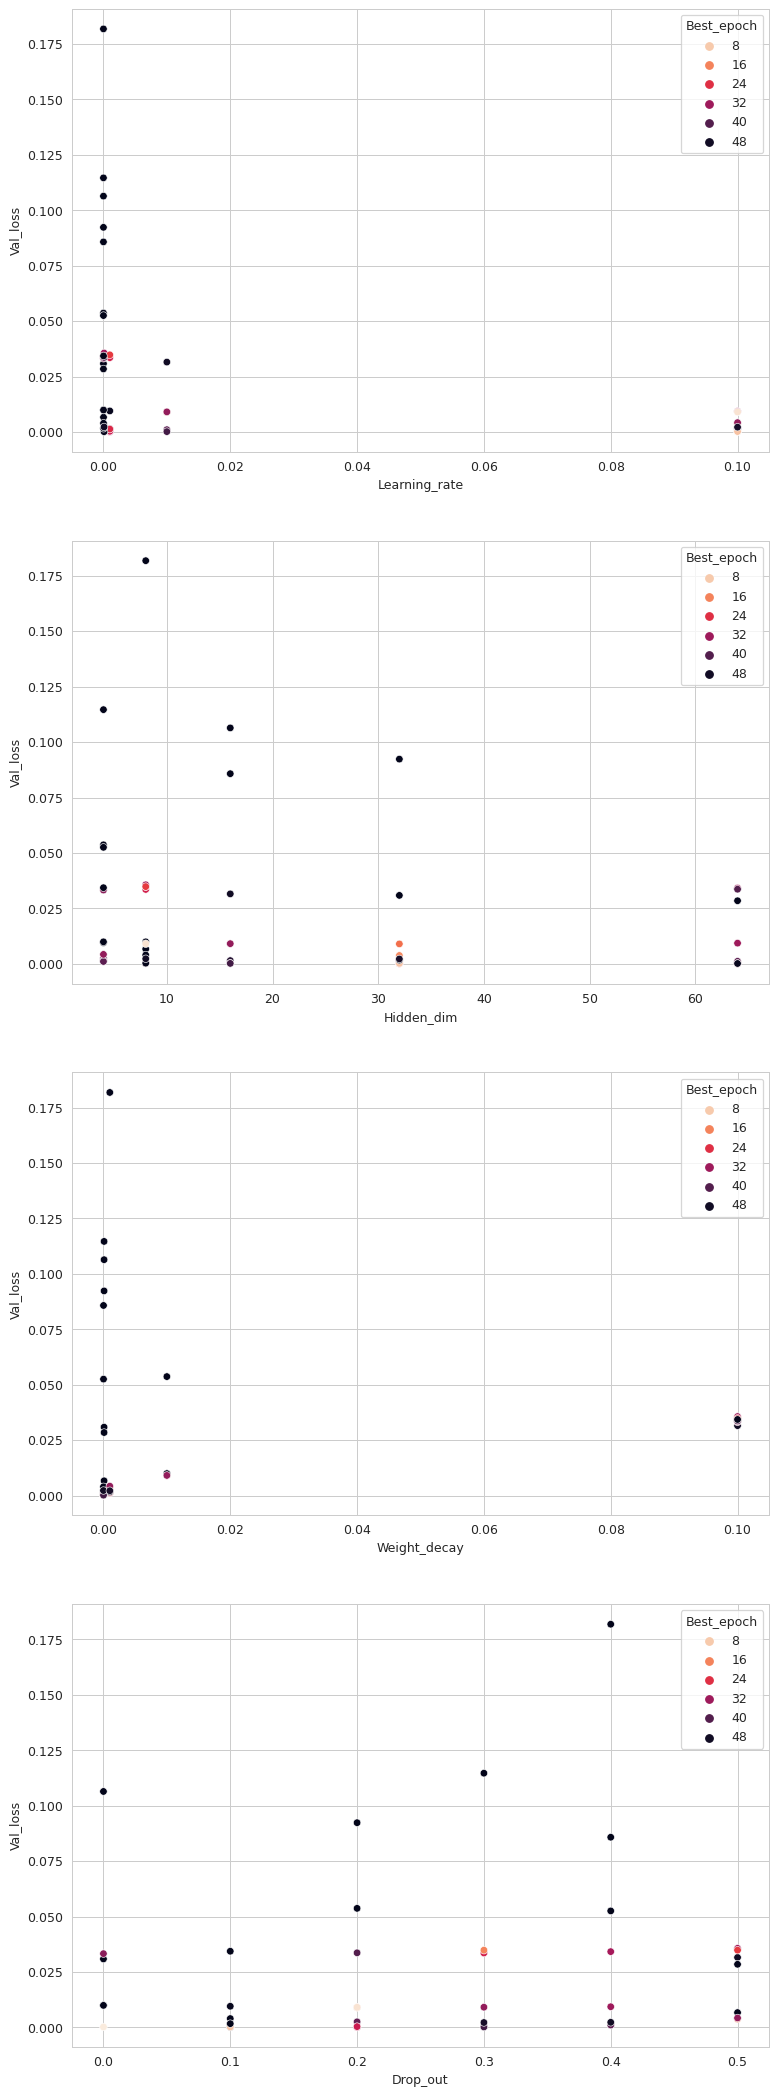

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(10, 30), dpi=90)

for idx, feat in enumerate(['Learning_rate', 'Hidden_dim', 'Weight_decay', 'Drop_out']):
    sns.scatterplot(x=feat,
                    y='Val_loss',
                    data=para_result,
                    palette=sns.color_palette('rocket_r', as_cmap=True),
                    hue='Best_epoch',
                    ax=axes[idx])

### 7.1.5 Further Grid Search on Selected Parameter

In [ ]:
# Fixed parameters

INPUT_DIM = 12 # when entity embedding size = 2
SAVE_MODEL_NAME = 'DisReg_MLP_tmp'
SAVE_MODEL_EPOCH = 1
N_EPOCHS = 50
SHOW_PROGRESS_EPOCH = N_EPOCHS+1
LEARNING_RATE = 1e-3
HIDDEN_DIM = 64
DROP_OUT = 0.2

In [ ]:
WEIGHT_DECAY = np.array([1e-5, 1e-6, 1e-7, 1e-8])

para_result = []

for wd in WEIGHT_DECAY:

    DisReg_MLP_tmp = DisReg_MLP_2Layer(
        INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

    optimiser = optim.Adam(
        DisReg_MLP_tmp.parameters(),
        lr=LEARNING_RATE, weight_decay=wd)
    
    criterion = torch.nn.MSELoss()

    train_model(DisReg_MLP_tmp,
            optimiser,
            criterion,
            N_EPOCHS,
            dl_train,
            dl_val, 
            SHOW_PROGRESS_EPOCH,
            SAVE_MODEL_EPOCH,
            SAVE_MODEL_NAME,
            continue_train = False, 
            previous_best_train_loss = 0,
            previous_lowest_val_loss = 0,
            best_model_state_dict = 0,
            previous_best_epoch = 0,
            previous_epochs = 0,
            previous_train_loss = 0,
            previous_val_loss = 0)


    _, best_epoch, best_loss_train, lowest_loss_val, _, _, \
    _, _, _ = load_model(
        SAVE_MODEL_NAME, 
        DisReg_MLP_tmp, 
        DisReg_MLP_tmp)

    print(
        'Weight decay: {}, Train loss: {:.7f}, Val loss: {:.7f}'.format(
            wd, best_loss_train, lowest_loss_val)
        )
    print('')

    para_result.append([wd, best_epoch, best_loss_train, lowest_loss_val])


para_result = pd.DataFrame(
    para_result, 
    columns=[
             'Weight_decay',
             'Best_epoch',
             'Train_loss',
             'Val_loss'
    ])

file_path = '/content/drive/My Drive/Colab Notebooks/DATA5703/section_7_1_5_para_result.m'
joblib.dump(para_result, file_path)

Training complete in: 0:02:17. Lowest validation loss occurred at epoch 10: 0.0001848
Weight decay: 1e-05, Train loss: 0.0003335, Val loss: 0.0001848

Training complete in: 0:02:19. Lowest validation loss occurred at epoch 43: 0.0001601
Weight decay: 1e-06, Train loss: 0.0003151, Val loss: 0.0001601

Training complete in: 0:02:16. Lowest validation loss occurred at epoch 39: 0.0001558
Weight decay: 1e-07, Train loss: 0.0003161, Val loss: 0.0001558

Training complete in: 0:02:19. Lowest validation loss occurred at epoch 50: 0.0001582
Weight decay: 1e-08, Train loss: 0.0002929, Val loss: 0.0001582



['/content/drive/My Drive/Colab Notebooks/DATA5703/section_7_1_5_para_result.m']

### 7.1.6 Load Grid Search Result

We can see that weight decay of 1e-7 resulted in lowest validation loss of 0.000156.

Best parameters are:

* Learning Rate = 1e-3
* Hidden Dimension = 64
* Drop Out = 0.2
* Weight Decay = 1e-7

In [ ]:
file_path = '/content/drive/My Drive/Colab Notebooks/DATA5703/section_7_1_5_para_result.m'

para_result = joblib.load(file_path)

display(para_result[para_result.Val_loss == para_result.Val_loss.min()])

,Weight_decay,Best_epoch,Train_loss,Val_loss
2,1.000000e-07,39,0.000316,0.000156


## 7.2 Hyperparameter exploration with basic 3-layer MLP model with entity embedding size of 2

**Ensure entity embeddings with size 2 were loaded in Data Processing**

### 7.2.1 Define Model

In [ ]:
class DisReg_MLP_3Layer(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, p):
        super(DisReg_MLP_3Layer, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, 1)

        self.act_1 = nn.ReLU()
        self.act_2 = nn.ReLU()
        self.act_3 = nn.Sigmoid()

        self.drop_1 = nn.Dropout(p)
        self.drop_2 = nn.Dropout(p)

    def forward(self, data):
        output = self.fc1(data)
        output = self.act_1(output)
        output = self.drop_1(output)

        output = self.fc2(output)
        output = self.act_2(output)
        output = self.drop_2(output)

        output = self.fc3(output)
        output = self.act_3(output)

        return output

### 7.2.2 Random Search

In [ ]:
# Fixed parameters

INPUT_DIM = 12 # when entity embedding size = 2
SAVE_MODEL_NAME = 'DisReg_MLP_tmp'
SAVE_MODEL_EPOCH = 1
N_EPOCHS = 50
SHOW_PROGRESS_EPOCH = N_EPOCHS+1

In [ ]:
# Random Search

np.random.seed(32)

LEARNING_RATE = np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
HIDDEN_DIM_1 = np.array([8, 16, 32, 64])
WEIGHT_DECAY = np.array([1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8])
DROP_OUT = np.array([0., 0.1, 0.2, 0.3, 0.4, 0.5])

para_result = []

N_TRIAL = 50

for trial in range(1, N_TRIAL+1):
    lr = np.random.choice(LEARNING_RATE)
    hd_1 = np.random.choice(HIDDEN_DIM_1)
    hd_2 = int(0.5*hd_1)
    wd = np.random.choice(WEIGHT_DECAY)
    dp = np.random.choice(DROP_OUT)

    DisReg_MLP_tmp = DisReg_MLP_3Layer(
        INPUT_DIM, hd_1, hd_2, dp).to(device)

    optimiser = optim.Adam(
        DisReg_MLP_tmp.parameters(),
        lr=lr, weight_decay=wd)
    
    criterion = torch.nn.MSELoss()

    print('Trial# ', trial)

    train_model(DisReg_MLP_tmp,
            optimiser,
            criterion,
            N_EPOCHS,
            dl_train,
            dl_val, 
            SHOW_PROGRESS_EPOCH,
            SAVE_MODEL_EPOCH,
            SAVE_MODEL_NAME,
            continue_train = False, 
            previous_best_train_loss = 0,
            previous_lowest_val_loss = 0,
            best_model_state_dict = 0,
            previous_best_epoch = 0,
            previous_epochs = 0,
            previous_train_loss = 0,
            previous_val_loss = 0)


    _, best_epoch, best_loss_train, lowest_loss_val, _, _, \
    _, _, _ = load_model(
        SAVE_MODEL_NAME, 
        DisReg_MLP_tmp, 
        DisReg_MLP_tmp)

    print(
        'Learning rate: {}, Hidden dim 1: {}, Hidden dim 2: {}, Weight decay: {},'\
        'Drop out: {}, Train loss: {:.7f}, Val loss: {:.7f}'.format(
            lr, hd_1, hd_2, wd, dp, best_loss_train, lowest_loss_val)
        )
    print('')

    para_result.append([lr, hd_1, hd_2, wd, dp, best_epoch, best_loss_train, lowest_loss_val])


para_result = pd.DataFrame(
    para_result, 
    columns=[
             'Learning_rate',
             'Hidden_dim_1',
             'Hidden_dim_2',
             'Weight_decay',
             'Drop_out',
             'Best_epoch',
             'Train_loss',
             'Val_loss'
    ])

file_path = '/content/drive/My Drive/Colab Notebooks/DATA5703/section_7_2_2_para_result.m'
joblib.dump(para_result, file_path)

Trial#  1
Training complete in: 0:02:51. Lowest validation loss occurred at epoch 50: 0.0001795
Learning rate: 0.0001, Hidden dim 1: 16, Hidden dim 2: 8, Weight decay: 1e-07,Drop out: 0.0, Train loss: 0.0001839, Val loss: 0.0001795

Trial#  2
Training complete in: 0:02:55. Lowest validation loss occurred at epoch 49: 0.001267
Learning rate: 0.0001, Hidden dim 1: 8, Hidden dim 2: 4, Weight decay: 0.0001,Drop out: 0.3, Train loss: 0.0045466, Val loss: 0.0012667

Trial#  3
Training complete in: 0:02:57. Lowest validation loss occurred at epoch 50: 0.02544
Learning rate: 1e-06, Hidden dim 1: 32, Hidden dim 2: 16, Weight decay: 0.0001,Drop out: 0.4, Train loss: 0.0332018, Val loss: 0.0254442

Trial#  4
Training complete in: 0:02:57. Lowest validation loss occurred at epoch 50: 0.00055
Learning rate: 0.0001, Hidden dim 1: 16, Hidden dim 2: 8, Weight decay: 1e-06,Drop out: 0.1, Train loss: 0.0017264, Val loss: 0.0005500

Trial#  5
Training complete in: 0:02:56. Lowest validation loss occurred

['/content/drive/My Drive/Colab Notebooks/DATA5703/section_7_2_2_para_result.m']

### 7.2.3 Load Random Search Result

We can extract the combination of hyperparameters with the lowest validation loss.

In [ ]:
file_path = '/content/drive/My Drive/Colab Notebooks/DATA5703/section_7_2_2_para_result.m'

para_result = joblib.load(file_path)

In [ ]:
display(para_result[para_result.Val_loss == para_result.Val_loss.min()])

,Learning_rate,Hidden_dim_1,Hidden_dim_2,Weight_decay,Drop_out,Best_epoch,Train_loss,Val_loss
12,0.001,64,32,1.000000e-08,0.2,31,0.000497,0.000161


### 7.2.4 Plot Random Search Result

**Learning Rate**:

From the best parameters above, we can see the best learning rate is 0.001 which resulted in lowest validation loss at epoch 31. The speed of model convergence is acceptable. 

Therefore, we will keep learning rate of 0.001 as our best learning rate.

**Hidden Dimension 1**:

From the best parameters above, we can see the best hidden dimension is 64.

From the figure below, it looks like the size of hidden dimension does not have much impact on the model convergence speed or validation loss.

Therefore, we will keep hidden dimension of 64 as our best hidden dimension.

**Hidden Dimension 2**:

From the best parameters above, we can see the best hidden dimension is 32. We have also set hidden himension 2 as half of hidden dimension 1 for simplicity during random search.

We may further explore the size of hidden dimension 2 with grid search.

**Weight Decay**:

From both the best parameters above and the figure below, we can see that the best weight decay is 1e-8, which is the lowest value in our search range. We can perform further grid search around this value to fine tune the weight decay.

**Drop Out**:

From the best parameters above, we can see the best drop out rate is 0.2.

From the figure below, we can see that low validation loss can be achieved regardless of the magnitude of the drop out rate.

Therefore, we will keep drop out rate of 0.2 as our best drop out rate.

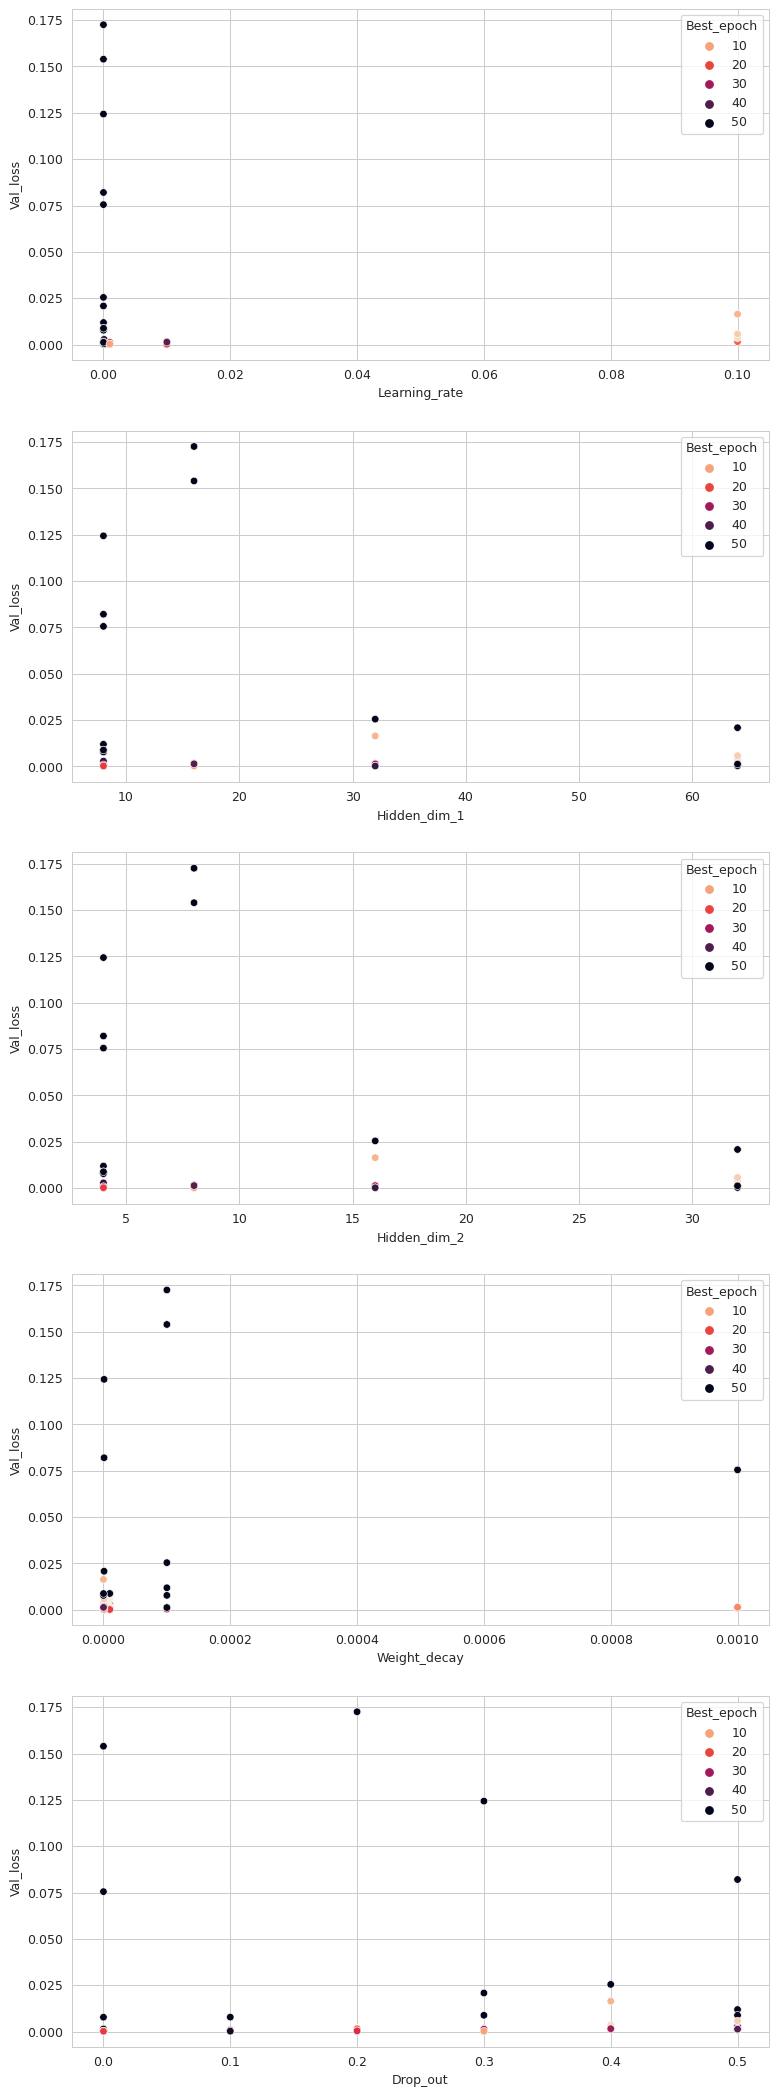

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(10, 30), dpi=90)

for idx, feat in enumerate(['Learning_rate', 'Hidden_dim_1', 'Hidden_dim_2', 'Weight_decay', 'Drop_out']):
    sns.scatterplot(x=feat,
                    y='Val_loss',
                    data=para_result,
                    palette=sns.color_palette('rocket_r', as_cmap=True),
                    hue='Best_epoch',
                    ax=axes[idx])

### 7.2.5 Further Grid Search on Selected Parameters

In [ ]:
# Fixed parameters

INPUT_DIM = 12 # when entity embedding size = 2
SAVE_MODEL_NAME = 'DisReg_MLP_tmp'
SAVE_MODEL_EPOCH = 1
N_EPOCHS = 50
SHOW_PROGRESS_EPOCH = N_EPOCHS+1
LEARNING_RATE = 1e-3
HIDDEN_DIM_1 = 64
DROP_OUT = 0.2

In [ ]:
WEIGHT_DECAY = np.array([1e-7, 1e-8, 1e-9, 1e-10])
HIDDEN_DIM_2 = np.array([8, 16, 32, 64])

para_result = []

for wd in WEIGHT_DECAY:
    for hd_2 in HIDDEN_DIM_2:

        DisReg_MLP_tmp = DisReg_MLP_3Layer(
            INPUT_DIM, HIDDEN_DIM_1, hd_2, DROP_OUT).to(device)

        optimiser = optim.Adam(
            DisReg_MLP_tmp.parameters(),
            lr=LEARNING_RATE, weight_decay=wd)
        
        criterion = torch.nn.MSELoss()

        train_model(DisReg_MLP_tmp,
                optimiser,
                criterion,
                N_EPOCHS,
                dl_train,
                dl_val, 
                SHOW_PROGRESS_EPOCH,
                SAVE_MODEL_EPOCH,
                SAVE_MODEL_NAME,
                continue_train = False, 
                previous_best_train_loss = 0,
                previous_lowest_val_loss = 0,
                best_model_state_dict = 0,
                previous_best_epoch = 0,
                previous_epochs = 0,
                previous_train_loss = 0,
                previous_val_loss = 0)


        _, best_epoch, best_loss_train, lowest_loss_val, _, _, \
        _, _, _ = load_model(
            SAVE_MODEL_NAME, 
            DisReg_MLP_tmp, 
            DisReg_MLP_tmp)

        print(
            'Weight decay: {}, Hidden dim 2: {}, Train loss: {:.7f}, Val loss: {:.7f}'.format(
                wd, hd_2, best_loss_train, lowest_loss_val)
            )
        print('')

        para_result.append([wd, hd_2, best_epoch, best_loss_train, lowest_loss_val])


para_result = pd.DataFrame(
    para_result, 
    columns=[
             'Weight_decay',
             'hidden_dim_2',
             'Best_epoch',
             'Train_loss',
             'Val_loss'
    ])

file_path = '/content/drive/My Drive/Colab Notebooks/DATA5703/section_7_2_5_para_result.m'
joblib.dump(para_result, file_path)

Training complete in: 0:03:48. Lowest validation loss occurred at epoch 50: 0.0001914
Weight decay: 1e-07, Hidden dim 2: 8, Train loss: 0.0011468, Val loss: 0.0001914

Training complete in: 0:03:48. Lowest validation loss occurred at epoch 26: 0.0001801
Weight decay: 1e-07, Hidden dim 2: 16, Train loss: 0.0009553, Val loss: 0.0001801

Training complete in: 0:03:47. Lowest validation loss occurred at epoch 44: 0.0001624
Weight decay: 1e-07, Hidden dim 2: 32, Train loss: 0.0005323, Val loss: 0.0001624

Training complete in: 0:03:46. Lowest validation loss occurred at epoch 40: 0.0001568
Weight decay: 1e-07, Hidden dim 2: 64, Train loss: 0.0003503, Val loss: 0.0001568

Training complete in: 0:03:46. Lowest validation loss occurred at epoch 34: 0.0001892
Weight decay: 1e-08, Hidden dim 2: 8, Train loss: 0.0013183, Val loss: 0.0001892

Training complete in: 0:03:46. Lowest validation loss occurred at epoch 41: 0.0001665
Weight decay: 1e-08, Hidden dim 2: 16, Train loss: 0.0007345, Val loss:

['/content/drive/My Drive/Colab Notebooks/DATA5703/section_7_2_5_para_result.m']

### 7.2.6 Load Grid Search Result

Best parameters are:

* Learning Rate = 1e-3
* Hidden Dimension 1 = 64
* Hidden Dimension 2 = 64
* Drop Out = 0.2
* Weight Decay = 1e-7

In [ ]:
file_path = '/content/drive/My Drive/Colab Notebooks/DATA5703/section_7_2_5_para_result.m'

para_result = joblib.load(file_path)

# show result with lowest validation loss
display(para_result[para_result.Val_loss == para_result.Val_loss.min()])

,Weight_decay,hidden_dim_2,Best_epoch,Train_loss,Val_loss
3,1.000000e-07,64,40,0.00035,0.000157


## 7.3 2-layer MLP model Entity Embedding exploration

### 7.3.1 Define 2-layer MLP Model

In [ ]:
class DisReg_MLP_2Layer(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, p):
        super(DisReg_MLP_2Layer, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, 1)

        self.act_1 = nn.ReLU()
        self.act_2 = nn.Sigmoid()

        self.drop_1 = nn.Dropout(p)

    def forward(self, data):

        output = self.fc1(data)
        output = self.act_1(output)
        output = self.drop_1(output)

        output = self.fc2(output)
        output = self.act_2(output)

        return output

### 7.3.2 Entity Embedding of size 2

* Ensure entity embedding of size 2 was loaded in Data Processing
* Train model with best parameters from section 7.1

In [ ]:
## Train new model

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-7
N_EPOCHS = 500
SHOW_PROGRESS_EPOCH = 10
SAVE_MODEL_EPOCH = 1
SAVE_MODEL_NAME = 'DisReg_MLP_2L_2'

INPUT_DIM = 12
HIDDEN_DIM = 64
DROP_OUT = 0.2

DisReg_MLP_2 = DisReg_MLP_2Layer(
    INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

optimiser = optim.Adam(DisReg_MLP_2.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

train_model(DisReg_MLP_2,
            optimiser,
            criterion,
            N_EPOCHS,
            dl_train,
            dl_val, 
            SHOW_PROGRESS_EPOCH,
            SAVE_MODEL_EPOCH,
            SAVE_MODEL_NAME,
            continue_train = False, 
            previous_best_train_loss = 0,
            previous_lowest_val_loss = 0,
            best_model_state_dict = 0,
            previous_best_epoch = 0,
            previous_epochs = 0,
            previous_train_loss = 0,
            previous_val_loss = 0)

Epoch: 10 Elapsed 0:00:03 | Train Loss: 0.0003287 | Val Loss: 0.0001759
Epoch: 20 Elapsed 0:00:03 | Train Loss: 0.0003064 | Val Loss: 0.0001725
Epoch: 30 Elapsed 0:00:03 | Train Loss: 0.0003045 | Val Loss: 0.0001648
Epoch: 40 Elapsed 0:00:03 | Train Loss: 0.0002977 | Val Loss: 0.0001828
Epoch: 50 Elapsed 0:00:03 | Train Loss: 0.0002935 | Val Loss: 0.0001661
Epoch: 60 Elapsed 0:00:03 | Train Loss: 0.000297 | Val Loss: 0.0001673
Epoch: 70 Elapsed 0:00:04 | Train Loss: 0.0002891 | Val Loss: 0.0001599
Epoch: 80 Elapsed 0:00:03 | Train Loss: 0.000293 | Val Loss: 0.0001571
Epoch: 90 Elapsed 0:00:03 | Train Loss: 0.0002997 | Val Loss: 0.000166
Epoch: 100 Elapsed 0:00:03 | Train Loss: 0.0002965 | Val Loss: 0.0001898
Epoch: 110 Elapsed 0:00:03 | Train Loss: 0.0003005 | Val Loss: 0.0001751
Epoch: 120 Elapsed 0:00:04 | Train Loss: 0.0002989 | Val Loss: 0.0001581
Epoch: 130 Elapsed 0:00:03 | Train Loss: 0.0002939 | Val Loss: 0.0001581
Epoch: 140 Elapsed 0:00:04 | Train Loss: 0.0002973 | Val Loss: 

In [ ]:
# Load Model

LOAD_MODEL_NAME = 'DisReg_MLP_2L_2'


LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-7

INPUT_DIM = 12
HIDDEN_DIM = 64
DROP_OUT = 0.2

best_model = DisReg_MLP_2Layer(
    INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

latest_model = DisReg_MLP_2Layer(
    INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

optimiser = optim.Adam(best_model.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

best_model, best_epoch, best_loss_train, lowest_loss_val, epochs, latest_model, \
    optimiser, total_losses_train, total_losses_val = load_model(
        LOAD_MODEL_NAME, best_model, latest_model)

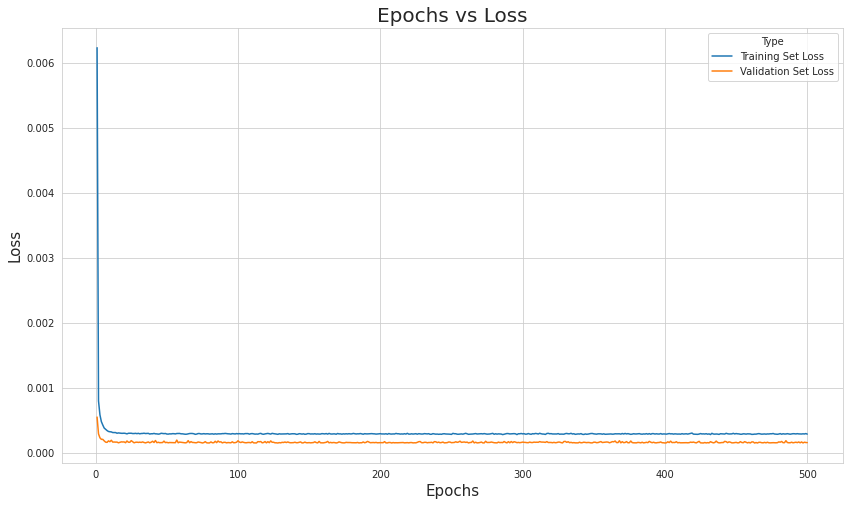

In [ ]:
# Save training log to dataframe format and plot log

train_loss_df = pd.DataFrame(zip(epochs, total_losses_train), columns=[
    'Epochs', 'Loss'])
train_loss_df['Type'] = 'Training Set Loss'
val_loss_df = pd.DataFrame(zip(epochs, total_losses_val), columns=[
    'Epochs', 'Loss'])
val_loss_df['Type'] = 'Validation Set Loss'
loss_df = pd.concat([train_loss_df, val_loss_df], axis=0)


plt.figure(figsize=(14, 8))
g = sns.lineplot(x='Epochs',
             y='Loss',
             data=loss_df,
             hue='Type')

g.set_title('Epochs vs Loss', fontsize=20)
g.set_xlabel('Epochs', fontsize=15)
g.set_ylabel('Loss', fontsize=15)

plt.show()

In [ ]:
# evaluate test loss with best model

test_losses = []

for test_data, test_label in dl_test:

    # convert to cuda if available
    test_data = test_data.float().to(device)
    test_label = test_label.float().to(device)

    best_model.eval()

    with torch.no_grad():
        output = best_model(test_data)
        loss = criterion(output.squeeze(), test_label)

    test_losses.append(loss.item())

# get average test loss
test_losses = np.average(test_losses)
print('Average Test Set MSE: {:.4}'.format(test_losses))

# test loss at original scale (km)
print('Average Test Set MSE at km: {:.4}'.format(
    scaler_dic['workout_distance'].inverse_transform(test_losses.reshape(1, -1))[0][0]))

Average Test Set MSE: 0.0001545
Average Test Set MSE at km: 0.02025


### 7.3.3 Entity Embedding of size 11

* Ensure entity embedding of size 11 was loaded in Data Processing
* Train model with best parameters from section 7.1

In [ ]:
## Train new model

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-7
N_EPOCHS = 500
SHOW_PROGRESS_EPOCH = 10
SAVE_MODEL_EPOCH = 1
SAVE_MODEL_NAME = 'DisReg_MLP_2L_11'

INPUT_DIM = 30
HIDDEN_DIM = 64
DROP_OUT = 0.2

DisReg_MLP_2 = DisReg_MLP_2Layer(
    INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

optimiser = optim.Adam(DisReg_MLP_2.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

train_model(DisReg_MLP_2,
            optimiser,
            criterion,
            N_EPOCHS,
            dl_train,
            dl_val, 
            SHOW_PROGRESS_EPOCH,
            SAVE_MODEL_EPOCH,
            SAVE_MODEL_NAME,
            continue_train = False, 
            previous_best_train_loss = 0,
            previous_lowest_val_loss = 0,
            best_model_state_dict = 0,
            previous_best_epoch = 0,
            previous_epochs = 0,
            previous_train_loss = 0,
            previous_val_loss = 0)

Epoch: 10 Elapsed 0:00:03 | Train Loss: 0.0003547 | Val Loss: 0.0001795
Epoch: 20 Elapsed 0:00:03 | Train Loss: 0.000324 | Val Loss: 0.0001854
Epoch: 30 Elapsed 0:00:03 | Train Loss: 0.0003084 | Val Loss: 0.0001746
Epoch: 40 Elapsed 0:00:03 | Train Loss: 0.000303 | Val Loss: 0.0001542
Epoch: 50 Elapsed 0:00:03 | Train Loss: 0.000299 | Val Loss: 0.00016
Epoch: 60 Elapsed 0:00:03 | Train Loss: 0.0002997 | Val Loss: 0.0001558
Epoch: 70 Elapsed 0:00:03 | Train Loss: 0.0002981 | Val Loss: 0.0001649
Epoch: 80 Elapsed 0:00:03 | Train Loss: 0.0003001 | Val Loss: 0.0001601
Epoch: 90 Elapsed 0:00:03 | Train Loss: 0.0002936 | Val Loss: 0.0001537
Epoch: 100 Elapsed 0:00:03 | Train Loss: 0.0002957 | Val Loss: 0.0001569
Epoch: 110 Elapsed 0:00:03 | Train Loss: 0.0002875 | Val Loss: 0.0001681
Epoch: 120 Elapsed 0:00:03 | Train Loss: 0.0002951 | Val Loss: 0.0001535
Epoch: 130 Elapsed 0:00:03 | Train Loss: 0.0002937 | Val Loss: 0.0001543
Epoch: 140 Elapsed 0:00:03 | Train Loss: 0.0002889 | Val Loss: 0.

In [ ]:
# Load Model

LOAD_MODEL_NAME = 'DisReg_MLP_2L_11'


LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-7

INPUT_DIM = 30
HIDDEN_DIM = 64
DROP_OUT = 0.2

best_model = DisReg_MLP_2Layer(
    INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

latest_model = DisReg_MLP_2Layer(
    INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

optimiser = optim.Adam(best_model.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

best_model, best_epoch, best_loss_train, lowest_loss_val, epochs, latest_model, \
    optimiser, total_losses_train, total_losses_val = load_model(
        LOAD_MODEL_NAME, best_model, latest_model)

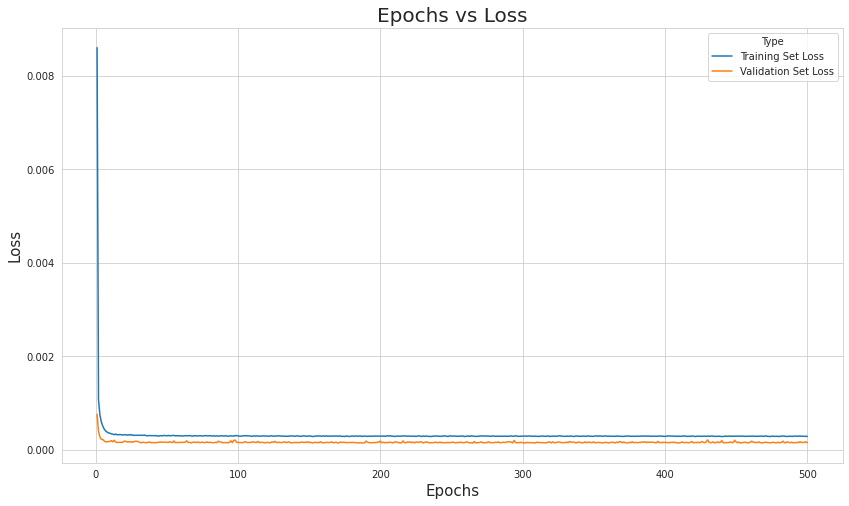

In [ ]:
# Save training log to dataframe format and plot log

train_loss_df = pd.DataFrame(zip(epochs, total_losses_train), columns=[
    'Epochs', 'Loss'])
train_loss_df['Type'] = 'Training Set Loss'
val_loss_df = pd.DataFrame(zip(epochs, total_losses_val), columns=[
    'Epochs', 'Loss'])
val_loss_df['Type'] = 'Validation Set Loss'
loss_df = pd.concat([train_loss_df, val_loss_df], axis=0)


plt.figure(figsize=(14, 8))
g = sns.lineplot(x='Epochs',
             y='Loss',
             data=loss_df,
             hue='Type')

g.set_title('Epochs vs Loss', fontsize=20)
g.set_xlabel('Epochs', fontsize=15)
g.set_ylabel('Loss', fontsize=15)

plt.show()

In [ ]:
# evaluate test loss with best model

test_losses = []

for test_data, test_label in dl_test:

    # convert to cuda if available
    test_data = test_data.float().to(device)
    test_label = test_label.float().to(device)

    best_model.eval()

    with torch.no_grad():
        output = best_model(test_data)
        loss = criterion(output.squeeze(), test_label)

    test_losses.append(loss.item())

# get average test loss
test_losses = np.average(test_losses)
print('Average Test Set MSE: {:.4}'.format(test_losses))

# test loss at original scale (km)
print('Average Test Set MSE at km: {:.4}'.format(
    scaler_dic['workout_distance'].inverse_transform(test_losses.reshape(1, -1))[0][0]))

Average Test Set MSE: 0.0001483
Average Test Set MSE at km: 0.01944


### 7.3.4 Entity Embedding of size 13

* Ensure entity embedding of size 13 was loaded in Data Processing
* Train model with best parameters from section 7.1

In [ ]:
## Train new model

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-7
N_EPOCHS = 500
SHOW_PROGRESS_EPOCH = 10
SAVE_MODEL_EPOCH = 1
SAVE_MODEL_NAME = 'DisReg_MLP_2L_13'

INPUT_DIM = 34
HIDDEN_DIM = 64
DROP_OUT = 0.2

DisReg_MLP_2 = DisReg_MLP_2Layer(
    INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

optimiser = optim.Adam(DisReg_MLP_2.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

train_model(DisReg_MLP_2,
            optimiser,
            criterion,
            N_EPOCHS,
            dl_train,
            dl_val, 
            SHOW_PROGRESS_EPOCH,
            SAVE_MODEL_EPOCH,
            SAVE_MODEL_NAME,
            continue_train = False, 
            previous_best_train_loss = 0,
            previous_lowest_val_loss = 0,
            best_model_state_dict = 0,
            previous_best_epoch = 0,
            previous_epochs = 0,
            previous_train_loss = 0,
            previous_val_loss = 0)

Epoch: 10 Elapsed 0:00:03 | Train Loss: 0.0003307 | Val Loss: 0.0001667
Epoch: 20 Elapsed 0:00:03 | Train Loss: 0.0003067 | Val Loss: 0.0001601
Epoch: 30 Elapsed 0:00:03 | Train Loss: 0.000313 | Val Loss: 0.0001659
Epoch: 40 Elapsed 0:00:03 | Train Loss: 0.0003073 | Val Loss: 0.0001594
Epoch: 50 Elapsed 0:00:03 | Train Loss: 0.000293 | Val Loss: 0.0001989
Epoch: 60 Elapsed 0:00:03 | Train Loss: 0.0002913 | Val Loss: 0.0001548
Epoch: 70 Elapsed 0:00:03 | Train Loss: 0.0002864 | Val Loss: 0.0001585
Epoch: 80 Elapsed 0:00:03 | Train Loss: 0.0002912 | Val Loss: 0.00016
Epoch: 90 Elapsed 0:00:03 | Train Loss: 0.0002925 | Val Loss: 0.0001506
Epoch: 100 Elapsed 0:00:03 | Train Loss: 0.0002846 | Val Loss: 0.0001741
Epoch: 110 Elapsed 0:00:03 | Train Loss: 0.0002952 | Val Loss: 0.0001768
Epoch: 120 Elapsed 0:00:03 | Train Loss: 0.000292 | Val Loss: 0.0001546
Epoch: 130 Elapsed 0:00:03 | Train Loss: 0.0002919 | Val Loss: 0.0001617
Epoch: 140 Elapsed 0:00:03 | Train Loss: 0.0002941 | Val Loss: 0.

In [ ]:
# Load Model

LOAD_MODEL_NAME = 'DisReg_MLP_2L_13'


LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-7

INPUT_DIM = 34
HIDDEN_DIM = 64
DROP_OUT = 0.2

best_model = DisReg_MLP_2Layer(
    INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

latest_model = DisReg_MLP_2Layer(
    INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

optimiser = optim.Adam(best_model.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

best_model, best_epoch, best_loss_train, lowest_loss_val, epochs, latest_model, \
    optimiser, total_losses_train, total_losses_val = load_model(
        LOAD_MODEL_NAME, best_model, latest_model)

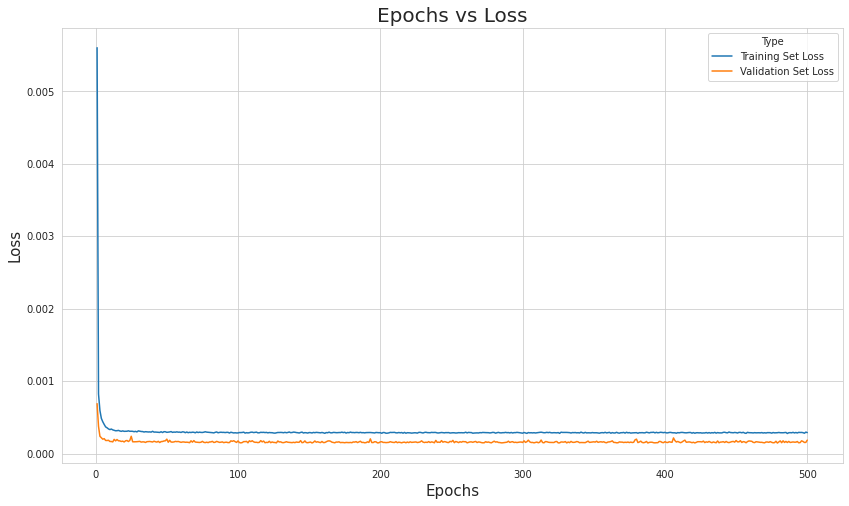

In [ ]:
# Save training log to dataframe format and plot log

train_loss_df = pd.DataFrame(zip(epochs, total_losses_train), columns=[
    'Epochs', 'Loss'])
train_loss_df['Type'] = 'Training Set Loss'
val_loss_df = pd.DataFrame(zip(epochs, total_losses_val), columns=[
    'Epochs', 'Loss'])
val_loss_df['Type'] = 'Validation Set Loss'
loss_df = pd.concat([train_loss_df, val_loss_df], axis=0)


plt.figure(figsize=(14, 8))
g = sns.lineplot(x='Epochs',
             y='Loss',
             data=loss_df,
             hue='Type')

g.set_title('Epochs vs Loss', fontsize=20)
g.set_xlabel('Epochs', fontsize=15)
g.set_ylabel('Loss', fontsize=15)

plt.show()

In [ ]:
# evaluate test loss with best model

test_losses = []

for test_data, test_label in dl_test:

    # convert to cuda if available
    test_data = test_data.float().to(device)
    test_label = test_label.float().to(device)

    best_model.eval()

    with torch.no_grad():
        output = best_model(test_data)
        loss = criterion(output.squeeze(), test_label)

    test_losses.append(loss.item())

# get average test loss
test_losses = np.average(test_losses)
print('Average Test Set MSE: {:.4}'.format(test_losses))

# test loss at original scale (km)
print('Average Test Set MSE at km: {:.4}'.format(
    scaler_dic['workout_distance'].inverse_transform(test_losses.reshape(1, -1))[0][0]))

Average Test Set MSE: 0.0001468
Average Test Set MSE at km: 0.01924


## 7.4 3-layer MLP model Entity Embedding Exploration

### 7.4.1 Define 3-layer MLP Model

In [ ]:
class DisReg_MLP_3Layer(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, p):
        super(DisReg_MLP_3Layer, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, 1)

        self.act_1 = nn.ReLU()
        self.act_2 = nn.ReLU()
        self.act_3 = nn.Sigmoid()

        self.drop_1 = nn.Dropout(p)
        self.drop_2 = nn.Dropout(p)

    def forward(self, data):
        output = self.fc1(data)
        output = self.act_1(output)
        output = self.drop_1(output)

        output = self.fc2(output)
        output = self.act_2(output)
        output = self.drop_2(output)

        output = self.fc3(output)
        output = self.act_3(output)

        return output

### 7.4.2 Entity Embedding of size 2

* Ensure entity embedding of size 2 was loaded in Data Processing
* Train model with best parameters from section 7.3

In [ ]:
## Train new model

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-7
N_EPOCHS = 500
SHOW_PROGRESS_EPOCH = 10
SAVE_MODEL_EPOCH = 1
SAVE_MODEL_NAME = 'DisReg_MLP_3L_2'

INPUT_DIM = 12
HIDDEN_DIM_1 = 64
HIDDEN_DIM_2 = 64
DROP_OUT = 0.2

DisReg_MLP_3 = DisReg_MLP_3Layer(
    INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, DROP_OUT).to(device)

optimiser = optim.Adam(DisReg_MLP_3.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

train_model(DisReg_MLP_3,
            optimiser,
            criterion,
            N_EPOCHS,
            dl_train,
            dl_val, 
            SHOW_PROGRESS_EPOCH,
            SAVE_MODEL_EPOCH,
            SAVE_MODEL_NAME,
            continue_train = False, 
            previous_best_train_loss = 0,
            previous_lowest_val_loss = 0,
            best_model_state_dict = 0,
            previous_best_epoch = 0,
            previous_epochs = 0,
            previous_train_loss = 0,
            previous_val_loss = 0)

Epoch: 10 Elapsed 0:00:04 | Train Loss: 0.0004153 | Val Loss: 0.0001869
Epoch: 20 Elapsed 0:00:05 | Train Loss: 0.0003806 | Val Loss: 0.0001731
Epoch: 30 Elapsed 0:00:05 | Train Loss: 0.0003774 | Val Loss: 0.0001814
Epoch: 40 Elapsed 0:00:04 | Train Loss: 0.0003751 | Val Loss: 0.0001652
Epoch: 50 Elapsed 0:00:04 | Train Loss: 0.000372 | Val Loss: 0.0001684
Epoch: 60 Elapsed 0:00:04 | Train Loss: 0.0003636 | Val Loss: 0.0001675
Epoch: 70 Elapsed 0:00:05 | Train Loss: 0.0003652 | Val Loss: 0.00022
Epoch: 80 Elapsed 0:00:04 | Train Loss: 0.0003677 | Val Loss: 0.0001821
Epoch: 90 Elapsed 0:00:05 | Train Loss: 0.0003553 | Val Loss: 0.000158
Epoch: 100 Elapsed 0:00:04 | Train Loss: 0.0003533 | Val Loss: 0.0001926
Epoch: 110 Elapsed 0:00:04 | Train Loss: 0.000345 | Val Loss: 0.0001644
Epoch: 120 Elapsed 0:00:05 | Train Loss: 0.0003513 | Val Loss: 0.0001633
Epoch: 130 Elapsed 0:00:05 | Train Loss: 0.0003615 | Val Loss: 0.0001834
Epoch: 140 Elapsed 0:00:05 | Train Loss: 0.000347 | Val Loss: 0.0

In [ ]:
LOAD_MODEL_NAME = 'DisReg_MLP_3L_2'


LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-7

INPUT_DIM = 12
HIDDEN_DIM_1 = 64
HIDDEN_DIM_2 = 64
DROP_OUT = 0.2

best_model = DisReg_MLP_3Layer(
    INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, DROP_OUT).to(device)

latest_model = DisReg_MLP_3Layer(
    INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, DROP_OUT).to(device)

optimiser = optim.Adam(best_model.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

best_model, best_epoch, best_loss_train, lowest_loss_val, epochs, latest_model, \
    optimiser, total_losses_train, total_losses_val = load_model(
        LOAD_MODEL_NAME, best_model, latest_model)

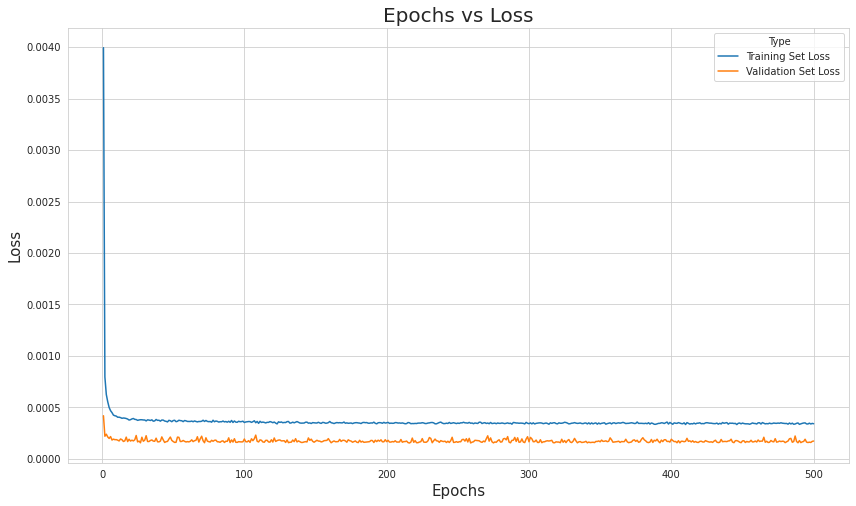

In [ ]:
# Save training log to dataframe format and plot log

train_loss_df = pd.DataFrame(zip(epochs, total_losses_train), columns=[
    'Epochs', 'Loss'])
train_loss_df['Type'] = 'Training Set Loss'
val_loss_df = pd.DataFrame(zip(epochs, total_losses_val), columns=[
    'Epochs', 'Loss'])
val_loss_df['Type'] = 'Validation Set Loss'
loss_df = pd.concat([train_loss_df, val_loss_df], axis=0)


plt.figure(figsize=(14, 8))
g = sns.lineplot(x='Epochs',
             y='Loss',
             data=loss_df,
             hue='Type')

g.set_title('Epochs vs Loss', fontsize=20)
g.set_xlabel('Epochs', fontsize=15)
g.set_ylabel('Loss', fontsize=15)

plt.show()

In [ ]:
# evaluate test loss with best model

test_losses = []

for test_data, test_label in dl_test:

    # convert to cuda if available
    test_data = test_data.float().to(device)
    test_label = test_label.float().to(device)

    best_model.eval()

    with torch.no_grad():
        output = best_model(test_data)
        loss = criterion(output.squeeze(), test_label)

    test_losses.append(loss.item())

# get average test loss
test_losses = np.average(test_losses)
print('Average Test Set MSE: {:.4}'.format(test_losses))

# test loss at original scale (km)
print('Average Test Set MSE at km: {:.4}'.format(
    scaler_dic['workout_distance'].inverse_transform(test_losses.reshape(1, -1))[0][0]))

Average Test Set MSE: 0.0001543
Average Test Set MSE at km: 0.02023


### 7.4.3 Entity Embedding of size 11

* Ensure entity embedding of size 11 was loaded in Data Processing
* Train model with best parameters from section 7.3

In [ ]:
## Train new model

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-7
N_EPOCHS = 500
SHOW_PROGRESS_EPOCH = 10
SAVE_MODEL_EPOCH = 1
SAVE_MODEL_NAME = 'DisReg_MLP_3L_11'

INPUT_DIM = 30
HIDDEN_DIM_1 = 64
HIDDEN_DIM_2 = 64
DROP_OUT = 0.2

DisReg_MLP_3 = DisReg_MLP_3Layer(
    INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, DROP_OUT).to(device)

optimiser = optim.Adam(DisReg_MLP_3.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

train_model(DisReg_MLP_3,
            optimiser,
            criterion,
            N_EPOCHS,
            dl_train,
            dl_val, 
            SHOW_PROGRESS_EPOCH,
            SAVE_MODEL_EPOCH,
            SAVE_MODEL_NAME,
            continue_train = False, 
            previous_best_train_loss = 0,
            previous_lowest_val_loss = 0,
            best_model_state_dict = 0,
            previous_best_epoch = 0,
            previous_epochs = 0,
            previous_train_loss = 0,
            previous_val_loss = 0)

Epoch: 10 Elapsed 0:00:04 | Train Loss: 0.0004226 | Val Loss: 0.0002244
Epoch: 20 Elapsed 0:00:04 | Train Loss: 0.0003902 | Val Loss: 0.0001798
Epoch: 30 Elapsed 0:00:04 | Train Loss: 0.0003759 | Val Loss: 0.0001764
Epoch: 40 Elapsed 0:00:03 | Train Loss: 0.000374 | Val Loss: 0.0001789
Epoch: 50 Elapsed 0:00:03 | Train Loss: 0.0003661 | Val Loss: 0.0002056
Epoch: 60 Elapsed 0:00:03 | Train Loss: 0.0003552 | Val Loss: 0.0001762
Epoch: 70 Elapsed 0:00:03 | Train Loss: 0.0003635 | Val Loss: 0.0001901
Epoch: 80 Elapsed 0:00:03 | Train Loss: 0.0003634 | Val Loss: 0.0001671
Epoch: 90 Elapsed 0:00:03 | Train Loss: 0.0003538 | Val Loss: 0.0001912
Epoch: 100 Elapsed 0:00:03 | Train Loss: 0.0003574 | Val Loss: 0.000172
Epoch: 110 Elapsed 0:00:03 | Train Loss: 0.0003478 | Val Loss: 0.0001612
Epoch: 120 Elapsed 0:00:03 | Train Loss: 0.0003606 | Val Loss: 0.000183
Epoch: 130 Elapsed 0:00:03 | Train Loss: 0.0003589 | Val Loss: 0.000155
Epoch: 140 Elapsed 0:00:03 | Train Loss: 0.0003512 | Val Loss: 0

In [ ]:
LOAD_MODEL_NAME = 'DisReg_MLP_3L_11'


LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-7

INPUT_DIM = 30
HIDDEN_DIM_1 = 64
HIDDEN_DIM_2 = 64
DROP_OUT = 0.2

best_model = DisReg_MLP_3Layer(
    INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, DROP_OUT).to(device)

latest_model = DisReg_MLP_3Layer(
    INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, DROP_OUT).to(device)

optimiser = optim.Adam(best_model.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

best_model, best_epoch, best_loss_train, lowest_loss_val, epochs, latest_model, \
    optimiser, total_losses_train, total_losses_val = load_model(
        LOAD_MODEL_NAME, best_model, latest_model)

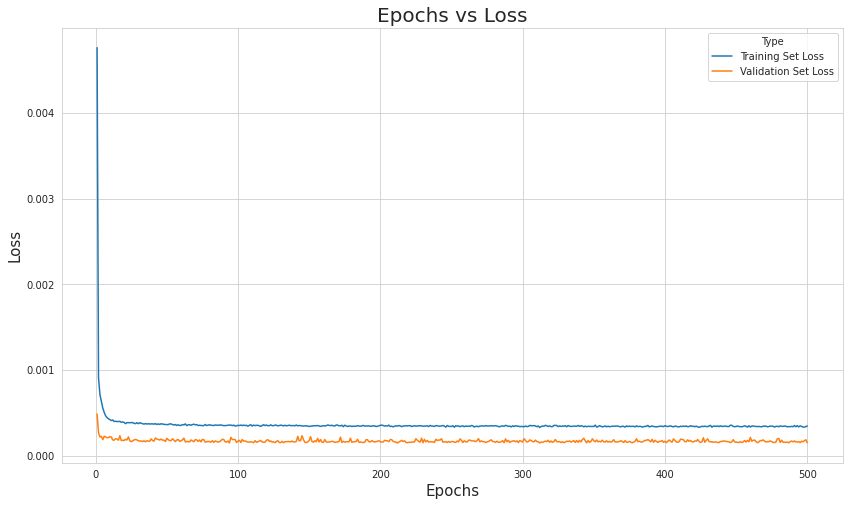

In [ ]:
# Save training log to dataframe format and plot log

train_loss_df = pd.DataFrame(zip(epochs, total_losses_train), columns=[
    'Epochs', 'Loss'])
train_loss_df['Type'] = 'Training Set Loss'
val_loss_df = pd.DataFrame(zip(epochs, total_losses_val), columns=[
    'Epochs', 'Loss'])
val_loss_df['Type'] = 'Validation Set Loss'
loss_df = pd.concat([train_loss_df, val_loss_df], axis=0)


plt.figure(figsize=(14, 8))
g = sns.lineplot(x='Epochs',
             y='Loss',
             data=loss_df,
             hue='Type')

g.set_title('Epochs vs Loss', fontsize=20)
g.set_xlabel('Epochs', fontsize=15)
g.set_ylabel('Loss', fontsize=15)

plt.show()

In [ ]:
# evaluate test loss with best model

test_losses = []

for test_data, test_label in dl_test:

    # convert to cuda if available
    test_data = test_data.float().to(device)
    test_label = test_label.float().to(device)

    best_model.eval()

    with torch.no_grad():
        output = best_model(test_data)
        loss = criterion(output.squeeze(), test_label)

    test_losses.append(loss.item())

# get average test loss
test_losses = np.average(test_losses)
print('Average Test Set MSE: {:.4}'.format(test_losses))

# test loss at original scale (km)
print('Average Test Set MSE at km: {:.4}'.format(
    scaler_dic['workout_distance'].inverse_transform(test_losses.reshape(1, -1))[0][0]))

Average Test Set MSE: 0.0001538
Average Test Set MSE at km: 0.02016


### 7.4.4 Entity Embedding of size 13

* Ensure entity embedding of size 13 was loaded in Data Processing
* Train model with best parameters from section 7.3

In [ ]:
## Train new model

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-7
N_EPOCHS = 500
SHOW_PROGRESS_EPOCH = 10
SAVE_MODEL_EPOCH = 1
SAVE_MODEL_NAME = 'DisReg_MLP_3L_13'

INPUT_DIM = 34
HIDDEN_DIM_1 = 64
HIDDEN_DIM_2 = 64
DROP_OUT = 0.2

DisReg_MLP_3 = DisReg_MLP_3Layer(
    INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, DROP_OUT).to(device)

optimiser = optim.Adam(DisReg_MLP_3.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

train_model(DisReg_MLP_3,
            optimiser,
            criterion,
            N_EPOCHS,
            dl_train,
            dl_val, 
            SHOW_PROGRESS_EPOCH,
            SAVE_MODEL_EPOCH,
            SAVE_MODEL_NAME,
            continue_train = False, 
            previous_best_train_loss = 0,
            previous_lowest_val_loss = 0,
            best_model_state_dict = 0,
            previous_best_epoch = 0,
            previous_epochs = 0,
            previous_train_loss = 0,
            previous_val_loss = 0)

Epoch: 10 Elapsed 0:00:03 | Train Loss: 0.0004431 | Val Loss: 0.0002178
Epoch: 20 Elapsed 0:00:03 | Train Loss: 0.0004005 | Val Loss: 0.000164
Epoch: 30 Elapsed 0:00:03 | Train Loss: 0.0003922 | Val Loss: 0.0001617
Epoch: 40 Elapsed 0:00:03 | Train Loss: 0.0003823 | Val Loss: 0.0001791
Epoch: 50 Elapsed 0:00:03 | Train Loss: 0.0003733 | Val Loss: 0.000182
Epoch: 60 Elapsed 0:00:03 | Train Loss: 0.000368 | Val Loss: 0.0001857
Epoch: 70 Elapsed 0:00:03 | Train Loss: 0.000374 | Val Loss: 0.0001777
Epoch: 80 Elapsed 0:00:03 | Train Loss: 0.0003662 | Val Loss: 0.0001574
Epoch: 90 Elapsed 0:00:03 | Train Loss: 0.000359 | Val Loss: 0.0001754
Epoch: 100 Elapsed 0:00:03 | Train Loss: 0.0003571 | Val Loss: 0.0001817
Epoch: 110 Elapsed 0:00:03 | Train Loss: 0.00037 | Val Loss: 0.0001971
Epoch: 120 Elapsed 0:00:03 | Train Loss: 0.0003573 | Val Loss: 0.0001653
Epoch: 130 Elapsed 0:00:03 | Train Loss: 0.0003624 | Val Loss: 0.0001673
Epoch: 140 Elapsed 0:00:03 | Train Loss: 0.0003575 | Val Loss: 0.00

In [ ]:
LOAD_MODEL_NAME = 'DisReg_MLP_3L_13'


LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-7

INPUT_DIM = 34
HIDDEN_DIM_1 = 64
HIDDEN_DIM_2 = 64
DROP_OUT = 0.2

best_model = DisReg_MLP_3Layer(
    INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, DROP_OUT).to(device)

latest_model = DisReg_MLP_3Layer(
    INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, DROP_OUT).to(device)

optimiser = optim.Adam(best_model.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

best_model, best_epoch, best_loss_train, lowest_loss_val, epochs, latest_model, \
    optimiser, total_losses_train, total_losses_val = load_model(
        LOAD_MODEL_NAME, best_model, latest_model)

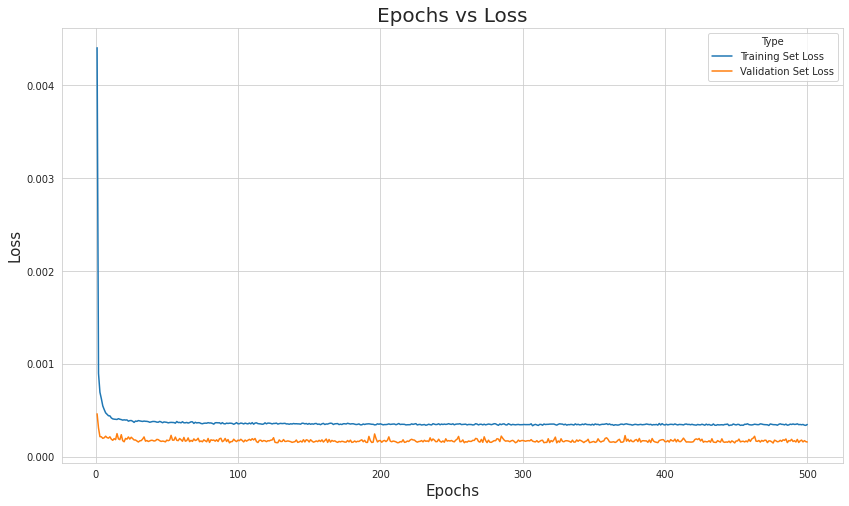

In [ ]:
# Save training log to dataframe format and plot log

train_loss_df = pd.DataFrame(zip(epochs, total_losses_train), columns=[
    'Epochs', 'Loss'])
train_loss_df['Type'] = 'Training Set Loss'
val_loss_df = pd.DataFrame(zip(epochs, total_losses_val), columns=[
    'Epochs', 'Loss'])
val_loss_df['Type'] = 'Validation Set Loss'
loss_df = pd.concat([train_loss_df, val_loss_df], axis=0)


plt.figure(figsize=(14, 8))
g = sns.lineplot(x='Epochs',
             y='Loss',
             data=loss_df,
             hue='Type')

g.set_title('Epochs vs Loss', fontsize=20)
g.set_xlabel('Epochs', fontsize=15)
g.set_ylabel('Loss', fontsize=15)

plt.show()

In [ ]:
# evaluate test loss with best model

test_losses = []

for test_data, test_label in dl_test:

    # convert to cuda if available
    test_data = test_data.float().to(device)
    test_label = test_label.float().to(device)

    best_model.eval()

    with torch.no_grad():
        output = best_model(test_data)
        loss = criterion(output.squeeze(), test_label)

    test_losses.append(loss.item())

# get average test loss
test_losses = np.average(test_losses)
print('Average Test Set MSE: {:.4}'.format(test_losses))

# test loss at original scale (km)
print('Average Test Set MSE at km: {:.4}'.format(
    scaler_dic['workout_distance'].inverse_transform(test_losses.reshape(1, -1))[0][0]))

Average Test Set MSE: 0.0001567
Average Test Set MSE at km: 0.02054


# 8. Best Model

We load the best model from experiments in section 7.

In [23]:
class DisReg_MLP_2Layer(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, p):
        super(DisReg_MLP_2Layer, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, 1)

        self.act_1 = nn.ReLU()
        self.act_2 = nn.Sigmoid()

        self.drop_1 = nn.Dropout(p)

    def forward(self, data):

        output = self.fc1(data)
        output = self.act_1(output)
        output = self.drop_1(output)

        output = self.fc2(output)
        output = self.act_2(output)

        return output

In [24]:
# Load Model

LOAD_MODEL_NAME = 'DisReg_MLP_2L_13'


LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-7

INPUT_DIM = 34
HIDDEN_DIM = 64
DROP_OUT = 0.2

best_model = DisReg_MLP_2Layer(
    INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

latest_model = DisReg_MLP_2Layer(
    INPUT_DIM, HIDDEN_DIM, DROP_OUT).to(device)

optimiser = optim.Adam(best_model.parameters(),
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

criterion = torch.nn.MSELoss()

best_model, best_epoch, best_loss_train, lowest_loss_val, epochs, latest_model, \
    optimiser, total_losses_train, total_losses_val = load_model(
        LOAD_MODEL_NAME, best_model, latest_model)

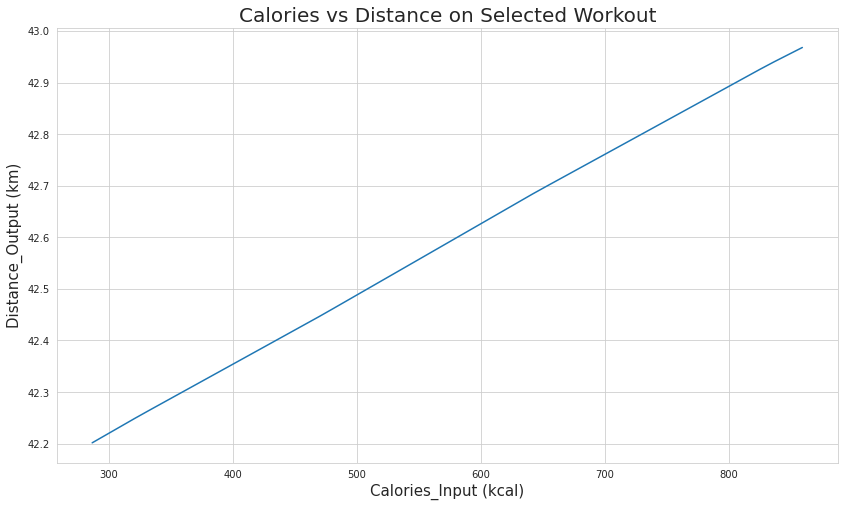

In [25]:
# select a random workout route from test set and check the relationship between
# calories input and distance output


idx = 12270
data_origin = ds_test[idx][0]
label_origin = ds_test[idx][1]
# original calorie input
cal_origin = data_origin[0]

# get calories from 0.5*original calories to 1.5*original calories
calories = np.arange(cal_origin*0.5, cal_origin*1.5, cal_origin/50)

data_new = []
pred = []

# prepare model input data for the calories range
for cal in calories:
    data_new.append(np.hstack((np.array(cal), data_origin[1:])))

# get model output for the calories range
best_model.eval()
with torch.no_grad():
    for data in data_new:
        pred.append(best_model(torch.Tensor(data).to(device)).item())

# convert calories and distance to original scale
calories = scaler_dic['calories'].inverse_transform(
    np.array(calories).reshape(-1, 1)).flatten()
pred = scaler_dic['workout_distance'].inverse_transform(
    np.array(pred).reshape(-1, 1)).flatten()


# convert to df and plot with seaborn
pred_df = pd.DataFrame(zip(calories, pred), columns=[
    'Calories_Input', 'Distance_Output'])

plt.figure(figsize=(14, 8))
g = sns.lineplot(
    x='Calories_Input',
    y='Distance_Output',
    data=pred_df)
g.set_title('Calories vs Distance on Selected Workout', fontsize=20)
g.set_xlabel('Calories_Input (kcal)', fontsize=15)
g.set_ylabel('Distance_Output (km)', fontsize=15)

plt.show()